# DDPG 算法

教程链接：[DDPG 算法](https://hrl.boyuai.com/chapter/2/ddpg%E7%AE%97%E6%B3%95)

In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class PolicyNet(nn.Module):
    """
    策略网络，也是Actor网络。目的是选出使得Q值最大的动作。
    """
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, action_bound:float
        ):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound

In [3]:
class QValueNet(nn.Module):
    def __init__(self, state_dim:int, hidden_dim:int, action_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x:torch.Tensor, a:torch.Tensor) -> torch.Tensor:
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [4]:
class DDPG(rl_utils.BasePolicy):
    ''' DDPG算法 '''
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, action_bound:float, 
            sigma:float, actor_lr:float, critic_lr:float, 
            tau:float, gamma:float, device:float
        ):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state:np.ndarray) -> np.ndarray:
        """
        选出动作，采用确定性策略，直接由策略网络输出动作。
        """
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net:nn.Module, target_net:nn.Module):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict:dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 训练目标：得到使Q值最大的动作
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

In [8]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 500
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 50/50 [01:12<00:00,  1.44s/it, episode=500, return=-428.154]


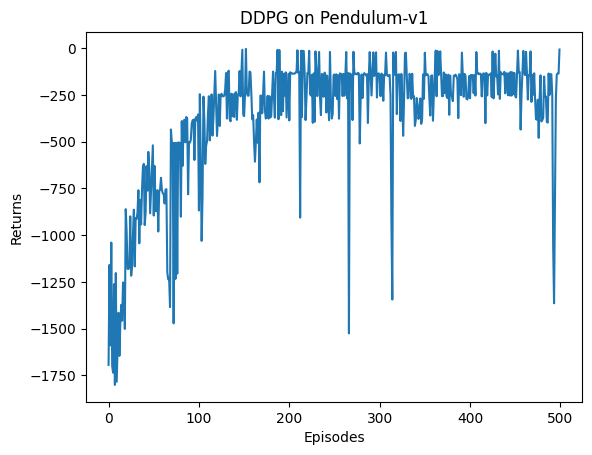

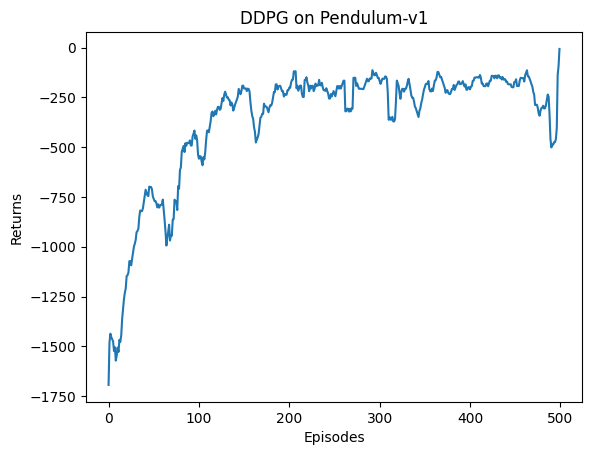

In [9]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()